# Captcha recognition

This notebook uses convolutional neural networks to determine the characters in the given captcha.

A base case implementation of recognizing text in images.

![](https://i.gifer.com/ARde.gif)

### Dataset

The link below contains the zipped dataset folder.

The dataset has 1070 captcha images, each with 5 characters. Each character is either a lowercase alphabet or a digit. 

The filename is of each image is its corresponding text.

In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/captcha.zip
!unzip captcha.zip

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image, ImageOps
from tensorflow.keras import layers
import random

The captcha in the images contains only lowercase alphabets and digits 0-9.

In [5]:
# The set of characters in the captcha

characters = 'abcdefghijklmnopqrstuvwxyz0123456789'
print("Number of characters: ", len(characters))

Number of characters:  36


In [6]:
# total number of images in dataset

total_samples = len(os.listdir('samples'))
print("Total number of images: ", total_samples)

Total number of images:  1070


Viewing few images in the dataset.

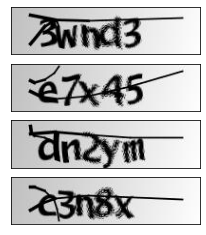

In [7]:
num = 4    # NUmber of examples to show
fig = plt.figure()

for i, filename in enumerate(os.listdir('samples')[:num]):
    img = Image.open('samples/'+filename)
    
    ax = fig.add_subplot(num, 1, i+1)    # Adding subplot
    ax.axes.get_xaxis().set_visible(False)    # Removing x axis
    ax.axes.get_yaxis().set_visible(False)    # Removing y axis
    
    ax.imshow(img)

## Preprocessing


Functions to one hot encode and decode all the characters in the captcha

In [10]:
def encode_label(label):   
    y_temp = np.zeros((5, len(characters)))     # Initializing zero array of required shape
    for k, l in enumerate(label):    
        index = characters.find(l)
        y_temp[k, index] = 1
    return y_temp

def decode_label(output):
    captcha = []
    for i in range(5):
        captcha.append(characters[np.argmax(output[i])])    # Find index of max value and map it to characters array
    return ''.join(captcha)

In [11]:
encoded = encode_label('22efd')

decoded = decode_label(encoded)

print("Encoded: ", encoded)
print("Decoded: ", decoded)

Encoded:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Decoded:  22efd


#### Input

The input X is the numpy array representation of each image. The images have 4 channels which are reduced to 1 by converting the image to greyscale. They are then normalized so that every pixel has a value between 0 and 1.

#### Output

The output y has 5 arrays representing the five characters required as output. Each of these arrays has a one hot encoded array of length 36 representing the ith (1 to 5) character for each input image.

In [12]:
X, y = [], np.zeros((5, total_samples, len(characters)))
images_list = os.listdir('samples')

for i in range(total_samples):
    img = Image.open('samples/'+images_list[i])
    img = ImageOps.grayscale(img)    # Convert to greyscale
    img = np.asarray(img)/255    # Normalization; shape of img = (50,200)
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))    # Adding another dimension to represent channel.
   
    label = images_list[i][:-4]    # The filename contains the captcha text.
    # One hot encoding
    y[:, i] = encode_label(label)    # Write to y array as output of ith image
   
    X.append(img)    # Appending to X

In [14]:
X = np.asarray(X)
y = np.asarray(y)

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (1070, 50, 200, 1)
Shape of y:  (5, 1070, 36)


Using a train-test split of 90-10

In [16]:
train_count = int(total_samples * 0.9)
test_count = total_samples-train_count

print("Images in train set: ", train_count)
print("Images in test set: ", test_count)

Images in train set:  963
Images in test set:  107


In [17]:
#Splitting the X and y arrays into train and test

xtrain, xtest = X[:train_count], X[train_count:] 
ytrain, ytest = y[:, :train_count], y[:, train_count:]

print("Train shapes: ", xtrain.shape, ytrain.shape)
print("Test shapes: ", xtest.shape, ytest.shape)

Train shapes:  (963, 50, 200, 1) (5, 963, 36)
Test shapes:  (107, 50, 200, 1) (5, 107, 36)


## Model 

The model has convolution and max pooling layers that branch into 5 dense networks, one for each character.

In [18]:
def create_model():
    input_layer = layers.Input(shape = xtrain[0].shape)
    
    conv1 = layers.Conv2D(8, (3, 3), padding = 'same', activation = 'relu')(input_layer)
    max1 = layers.MaxPooling2D(padding = 'same', )(conv1)
    
    conv2 =  layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(max1)
    max2 =  layers.MaxPooling2D(padding = 'same', )(conv2)
    
    conv3 =  layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(max2)
    max3 =  layers.MaxPooling2D(padding = 'same', )(conv3)
    
    batch3 =  layers.BatchNormalization()(max3)
    
    flat = layers.Flatten()(batch3)

    output_layers = []
    for _ in range(5):    # For all the 5 output characters
        dense1 = tf.keras.layers.Dense(32, activation='relu')(flat)
        drop = tf.keras.layers.Dropout(0.6)(dense1)
        dense2 = tf.keras.layers.Dense(len(characters), activation='sigmoid')(drop)
        output_layers.append(dense2)

    model = tf.keras.models.Model(input_layer, output_layers)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

In [19]:
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 200, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 100, 8)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 100, 16)  1168        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [63]:
# Evaluating an untrained model.

eval = model.evaluate(xtest,[ytest[0], ytest[1], ytest[2], ytest[3], ytest[4]],verbose=1)    

4/4 [==============================] - 0s 14ms/step - loss: 2.4669 - dense_21_loss: 0.0160 - dense_23_loss: 0.4061 - dense_25_loss: 0.5833 - dense_27_loss: 0.8832 - dense_29_loss: 0.5782 - dense_21_accuracy: 0.9907 - dense_23_accuracy: 0.9626 - dense_25_accuracy: 0.8879 - dense_27_accuracy: 0.8505 - dense_29_accuracy: 0.9159


### Training the model

Since the model has 5 different dense networks, one for each character, the y parameter of the model.fit() method is given a list of 5 arrays.

Training the model for 128 epochs.

In [20]:
 history = model.fit(xtrain, [ytrain[0], ytrain[1], ytrain[2], ytrain[3], ytrain[4]], batch_size=32, epochs=128, verbose=1)

Epoch 1/128
31/31 [==============================] - 2s 55ms/step - loss: 17.7109 - dense_1_loss: 3.5661 - dense_3_loss: 3.5360 - dense_5_loss: 3.4872 - dense_7_loss: 3.5505 - dense_9_loss: 3.5712 - dense_1_accuracy: 0.0613 - dense_3_accuracy: 0.0478 - dense_5_accuracy: 0.0498 - dense_7_accuracy: 0.0374 - dense_9_accuracy: 0.0374
Epoch 2/128
31/31 [==============================] - 2s 54ms/step - loss: 16.8376 - dense_1_loss: 3.3902 - dense_3_loss: 3.3260 - dense_5_loss: 3.2668 - dense_7_loss: 3.3888 - dense_9_loss: 3.4659 - dense_1_accuracy: 0.0685 - dense_3_accuracy: 0.0758 - dense_5_accuracy: 0.0582 - dense_7_accuracy: 0.0530 - dense_9_accuracy: 0.0633
Epoch 3/128
31/31 [==============================] - 2s 54ms/step - loss: 16.0339 - dense_1_loss: 3.2418 - dense_3_loss: 3.1295 - dense_5_loss: 3.0792 - dense_7_loss: 3.2082 - dense_9_loss: 3.3752 - dense_1_accuracy: 0.0737 - dense_3_accuracy: 0.1018 - dense_5_accuracy: 0.0831 - dense_7_accuracy: 0.0852 - dense_9_accuracy: 0.0613
Epoc

In [44]:
# Evaluating the trained model

eval = model.evaluate(xtest,[ytest[0], ytest[1], ytest[2], ytest[3], ytest[4]],verbose=1)

print("\nAccuracies of the 5 dense networks: ")
for i in range(-5, 0):
    print(eval[i])

4/4 [==============================] - 0s 32ms/step - loss: 2.3055 - dense_1_loss: 0.0077 - dense_3_loss: 0.4174 - dense_5_loss: 0.6194 - dense_7_loss: 0.6630 - dense_9_loss: 0.5980 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9346 - dense_5_accuracy: 0.8972 - dense_7_accuracy: 0.8692 - dense_9_accuracy: 0.9065

Accuracies of the 5 dense networks: 
1.0
0.9345794320106506
0.8971962332725525
0.8691588640213013
0.9065420627593994


## Plot

In [22]:
history_keys = list(history.history.keys())
history_keys

['loss',
 'dense_1_loss',
 'dense_3_loss',
 'dense_5_loss',
 'dense_7_loss',
 'dense_9_loss',
 'dense_1_accuracy',
 'dense_3_accuracy',
 'dense_5_accuracy',
 'dense_7_accuracy',
 'dense_9_accuracy']

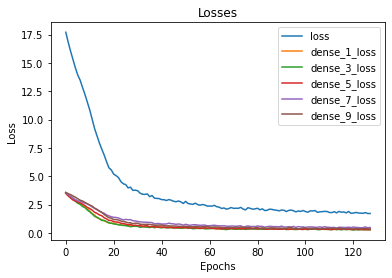

In [23]:
# Plotting the overall loss and losses of the 5 dense networks

for i in range(6):
    plt.plot(history.epoch, history.history[history_keys[i]])

plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend(history_keys[:6])

plt.show()

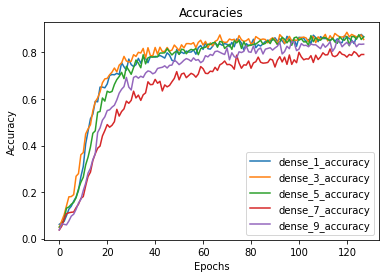

In [24]:
# Plotting the accuracies of the 5 dense networks

for i in range(6,11):
    plt.plot(history.epoch, history.history[history_keys[i]])

plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend(history_keys[6:11])

plt.show()

In [25]:
def predict(file):
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    img = np.asarray(img)/255
    img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
    
    output = np.asarray(model.predict(img))
    output = output.squeeze()    # Remove empty dimensions
    return decode_label(output)

Predicted:  nfg23


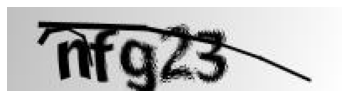

In [40]:
#i = random.randint(1, total_samples) # Pick one from all the image samples
i = random.randint(train_count, total_samples) # Pick one from only the test set

filename = 'samples/' + images_list[i]
plt.imshow(Image.open(filename))
plt.axis('off')    # Removing the axes

print("Predicted: ", predict(filename))

## deepC

In [99]:
model.save('captcha_model.h5')

In [100]:
!deepCC captcha_model.h5

reading [keras model] from 'captcha_model.h5'
Saved 'captcha_model.onnx'
reading onnx model from file  captcha_model.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added without this attribute.
WARN (ONNX): graph-node conv2d_14's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_13's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_12's attribute auto_pad has no meaningful data.
WARN (ONNX): terminal (input/output) input_5's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_33's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_33) as io node.
WARN (ONNX): terminal (input/output) dense_35's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_35) as io node.
WARN 

In [72]:
def input_to_deepC(file):
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    img = np.asarray(img)/255
    img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
    return img

In [ ]:
sample = x_test[1]
np.savetxt('sample.data', input_to_deepC(''))